In [1]:
##How to perform active machine learning

#Normal libraries

from pandas import read_csv
import pandas as pd
import numpy as np
import datetime

#Library to build a model using keras that is build on tensorflow
#(a library on how to handle tensor and their function)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

#Library to build generic models

from scipy.optimize import curve_fit


#Libraries about the learning process of the actual AI
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Useful libraries
from matplotlib import pyplot as plt
import math

2023-07-05 16:30:22.876284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 16:30:23.255097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 16:30:23.257143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 16:30:26.817475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Sensors = read_csv("/home/wvuser/challenge_3/appa1_timeline.csv",
                     sep = ",")
Sensors.set_index("channel", inplace = True)
Sensors = Sensors.applymap(lambda x: x.replace("*", ""))

dfSC = read_csv("/home/wvuser/challenge_3/StChiara_hourly.csv",
             sep = ",",
             parse_dates = ["ts"])
dfSC.set_index("ts", inplace = True)

change = {}
for i in range(1,9):
    change["S" +str(i)+"_R1"] = "T" + str(i)
    change["S" +str(i)+"_R2"] = "R" + str(i)
    change["S"+ str(i)+"_Voltage"] = "V"+str(i)
dfSC = dfSC.rename(columns=change)

In [3]:
Test = {}
maxim = len(Sensors.columns)
for i,col in enumerate(Sensors.columns):
    materials = []
    if i == maxim-1:
        for j,material in enumerate(Sensors[col]):
            f = materials.count(material)+1            
            materials.append(material)
            if list(Test.keys()).count(material + str(f)) == 1:
                Test[material + str(f)] = pd.concat([Test[material + str(f)],
                                                     dfSC[col:][["R"+str(j+1),
                                                                   "T"+str(j+1),
                                                                   "V"+str(j+1)]].rename(columns = {
                                                         "R"+str(j+1):"R",
                                                         "T"+str(j+1):"HT",
                                                         "V"+str(j+1):"V"
                                                     })])
            else:
                Test[material + str(f)] = dfSC[col:][["R"+str(j+1),
                                                                   "T"+str(j+1),
                                                                   "V"+str(j+1)]].rename(columns = {
                                                         "R"+str(j+1):"R",
                                                         "T"+str(j+1):"HT",
                                                         "V"+str(j+1):"V"
                                                     })    
    else:
        for j,material in enumerate(Sensors[col]):
            f = materials.count(material)+1            
            materials.append(material)
            if list(Test.keys()).count(material + str(f)) == 1:
                Test[material + str(f)] = pd.concat([Test[material + str(f)],
                                                     dfSC[col:Sensors.columns[i+1]][["R"+str(j+1),
                                                                   "T"+str(j+1),
                                                                   "V"+str(j+1)]].rename(columns = {
                                                         "R"+str(j+1):"R",
                                                         "T"+str(j+1):"HT",
                                                         "V"+str(j+1):"V"
                                                     })
                                                    ])
            else:
                Test[material + str(f)] = dfSC[col:Sensors.columns[i+1]][["R"+str(j+1),
                                                                   "T"+str(j+1),
                                                                   "V"+str(j+1)]].rename(columns = {
                                                         "R"+str(j+1):"R",
                                                         "T"+str(j+1):"HT",
                                                         "V"+str(j+1):"V"
                                                     })

In [4]:
dfSC = dfSC.apply(pd.to_numeric, errors='coerce')
dfSC = dfSC.dropna()

In [5]:
Test

{'ZnOR1':                                        R         HT         V
 ts                                                           
 2021-01-13 00:00:00+00:00            NaN        NaN       NaN
 2021-01-13 01:00:00+00:00            NaN        NaN       NaN
 2021-01-13 02:00:00+00:00            NaN        NaN       NaN
 2021-01-13 03:00:00+00:00            NaN        NaN       NaN
 2021-01-13 04:00:00+00:00            NaN        NaN       NaN
 ...                                  ...        ...       ...
 2023-06-26 05:00:00+00:00  161625.094828  68.558621  1.990172
 2023-06-26 06:00:00+00:00  162563.966667  68.520000  1.989667
 2023-06-26 07:00:00+00:00  166067.916667  68.536667  1.989500
 2023-06-26 08:00:00+00:00  171913.950000  68.570000  1.990000
 2023-06-26 09:00:00+00:00  173276.166667  68.616667  1.990000
 
 [21658 rows x 3 columns],
 'ZnOR2':                                        R         HT         V
 ts                                                           
 2021-01

In [6]:
dfAPPA = read_csv("/home/wvuser/challenge_3/APPA1.csv", parse_dates=["Time"])
dfAPPA = dfAPPA.rename(columns={"Time": "ts"})

In [7]:
dfAPPA.ts

0       2020-01-01 01:00:00
1       2020-01-01 02:00:00
2       2020-01-01 03:00:00
3       2020-01-01 04:00:00
4       2020-01-01 05:00:00
                ...        
33134   2022-03-04 14:00:00
33135   2022-06-21 14:00:00
33136   2022-09-02 11:00:00
33137   2023-02-01 13:00:00
33138   2023-04-26 14:00:00
Name: ts, Length: 33139, dtype: datetime64[ns]

In [8]:
timezone_offset = datetime.timedelta(hours=2)
timezone = datetime.timezone(timezone_offset)
dfAPPA.ts = dfAPPA.ts.apply(lambda x: x.replace(tzinfo=timezone))


# timezone_offset = datetime.timedelta(hours=0)
# timezone = datetime.timezone(timezone_offset)
# dfSC.ts = dfSC.ts.apply(lambda x: x.replace(tzinfo=timezone))

dfAPPA.rename(columns = {"Time":"ts"}, inplace = True)

In [9]:
df_tot = dfAPPA.merge(Test["ZnOR1"].reset_index())

In [10]:
df_tot

,ts,PM10,Biossido di Azoto,Biossido Zolfo,Ozono,PM2.5,R,HT,V
0,2021-01-13 02:00:00+02:00,49.0,68.0,3.0,4.0,30.0,NaN,NaN,NaN
1,2021-01-13 03:00:00+02:00,48.0,64.0,3.0,4.0,30.0,NaN,NaN,NaN
2,2021-01-13 04:00:00+02:00,44.0,64.0,3.0,4.0,29.0,NaN,NaN,NaN
3,2021-01-13 05:00:00+02:00,39.0,65.0,3.0,4.0,26.0,NaN,NaN,NaN
4,2021-01-13 06:00:00+02:00,35.0,67.0,3.0,3.0,23.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24226,2022-03-04 14:00:00+02:00,NaN,NaN,NaN,75.0,41.0,4.613902e+08,118.216667,3.9800
24227,2022-06-21 14:00:00+02:00,NaN,NaN,NaN,143.0,NaN,4.990000e+08,127.730000,4.0635
24228,2022-09-02 11:00:00+02:00,NaN,NaN,NaN,61.0,NaN,4.990000e+08,131.246667,3.8940
24229,2023-02-01 13:00:00+02:00,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN


In [11]:
df_tot = df_tot.set_index("ts")
df_tot = df_tot.sort_index()
df_tot = df_tot.dropna()

In [12]:
##Example of curve fit

##Define a model
def f_model(x, a, b, c, d, e):
    Sig,T,RH = x
    return a*Sig**b + d*T + e + c


##df8 is an example of a dataframe, indexed with data and with columns name not really informative

##### APPLICO MODEL 1 A df_tot (merge tra dfAPPA e Test) NEL PERIODO TRA 13-01-2021 E 13-02-2021
##### CONFRONTANDO UN SENRORE (R, V, HT) CON LA CONCENTRAZIONE DI OZONO NELL'ARIA
##You are training here from a start to end the slicing of a database
popt, pcov = curve_fit( #popt are the optimal values, pcov is the covariance matrix of the optimized values.
    f=f_model,       # model function
    xdata=(df_tot["2021-01-13":"2021-02-13"]["R"].values,
           df_tot["2021-01-13":"2021-02-13"]["V"].values,
           df_tot["2021-01-13":"2021-02-13"]["HT"].values),   # x data
    ydata=df_tot["2021-01-13":"2021-02-13"]["Ozono"].values,   # y data
    p0=(4, 1, 1, 1, 1), # initial value of the parameters
    maxfev=10000      #Number of times in which you repeat the training, close to epochs
)
a_opt,b_opt,c_opt,d_opt,e_opt = popt # optimal values
df_tot["model 1"] = f_model((df_tot["R"].values,
                         df_tot["V"].values,
                         df_tot["HT"].values), 
                        a_opt,
                        b_opt,
                        c_opt,
                        d_opt,
                        e_opt) #Here you are predicting the value of your complete samples

In [13]:
meanINVERNO2021 = df_tot["1/13/2021":"4/29/2021"].R.mean()
meanINVERNO2022 = df_tot["1/14/2022":"4/19/2022"].R.mean()

stdINVERNO2021 = df_tot["1/13/2021":"4/29/2021"].R.std()
stdINVERNO2022 = df_tot["1/14/2022":"4/19/2022"].R.std()

# sup = resistance of sensor 1 during winter
sup = (df_tot["1/13/2021":"4/29/2021"].R - meanINVERNO2021)/stdINVERNO2021
sup = stdINVERNO2022*sup+meanINVERNO2022

In [14]:
meanPRIM2021 = df_tot["4/29/2021":"6/30/2021"].R.mean()
meanPRIM2022 = df_tot["4/19/2022":"6/30/2022"].R.mean()

stdPRIM2021 = df_tot["4/29/2021":"6/30/2021"].R.std()
stdPRIM2022 = df_tot["4/19/2022":"6/30/2022"].R.std()

# sup2 = resistance of sensor 1 during spring
sup2 = (df_tot["4/29/2021":"6/30/2021"].R - meanPRIM2021)/stdPRIM2021
sup2 = stdPRIM2022*sup2 + meanPRIM2022

In [15]:
##### dfFINAL --> DOPO LA TRASFORMAZION DI STDEV
dfFINAL = df_tot[:"2/8/2023"].copy()
# #dfFINAL.R = pd.concat([sup,sup2,df_tot["6/30/2021":"2/8/2023"].R]).values
# dfFINAL["4/29/2021":"6/30/2021"].R.replace(value = sup.values, inplace = True)
# dfFINAL["1/14/2022":"4/19/2022"].R.replace(value  = sup2.values, inplace = True)
dfFINAL.loc["4/29/2021":"6/30/2021","R"] = sup2.loc["4/29/2021":"6/30/2021"].values
dfFINAL.loc["1/13/2021":"4/29/2021","R"] = sup.loc["1/13/2021":"4/29/2021"].values

In [16]:
##### APPLICO MODEL 2 A dfFINAL (df_tot DOPO LA TRASFORMAZION DI STDEV) NEL PERIODO TRA 13-03-2021 E 13-05-2021
##### CONFRONTANDO UN SENRORE (R, V, HT) CON LA CONCENTRAZIONE DI OZONO NELL'ARIA

popt, pcov = curve_fit( #popt are the optimal values, pcov is the covariance matrix of the optimized values.
    f=f_model,       # model function
    xdata=(dfFINAL["2021-03-13":"2021-05-13"]["R"].values,
           dfFINAL["2021-03-13":"2021-05-13"]["V"].values,
           dfFINAL["2021-03-13":"2021-05-13"]["HT"].values),   # x data
    ydata=dfFINAL["2021-03-13":"2021-05-13"]["Ozono"].values,   # y data
    p0=(4, 1, 1, 1, 1), # initial value of the parameters
    maxfev=10000      #Number of times in which you repeat the training, close to epochs
)
a_opt,b_opt,c_opt,d_opt,e_opt = popt # optimal values
dfFINAL["model 2"] = f_model((dfFINAL["R"].values,
                         dfFINAL["V"].values,
                         dfFINAL["HT"].values), 
                        a_opt,
                        b_opt,
                        c_opt,
                        d_opt,
                        e_opt) #Here you are predicting the value of your complete samples

/home/wvuser/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<function matplotlib.pyplot.show(close=None, block=None)>

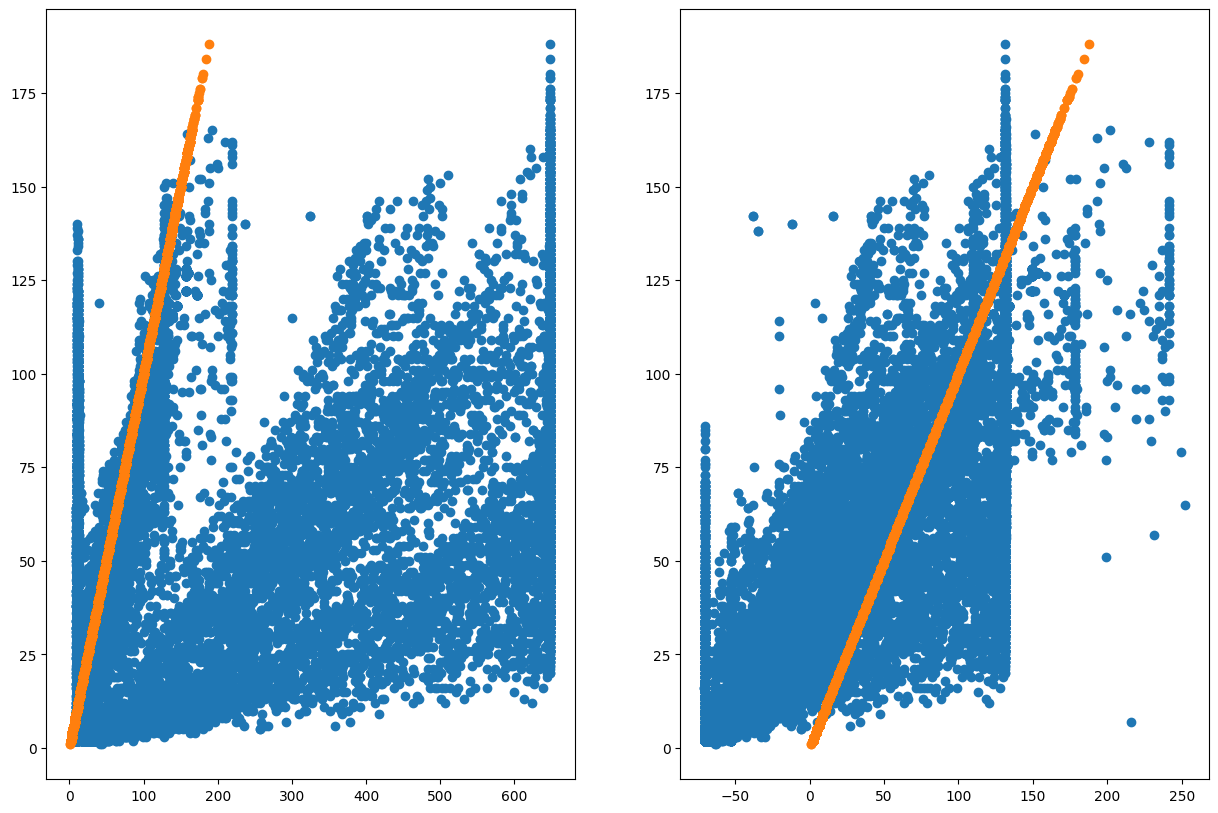

In [20]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.scatter(
    df_tot['model 1'],
    df_tot["Ozono"]
)
ax2.scatter(
    dfFINAL['model 2'],
    dfFINAL["Ozono"]
)
ax1.scatter(
    dfFINAL["Ozono"],
    dfFINAL["Ozono"]
)
ax2.scatter(
    dfFINAL["Ozono"],
    dfFINAL["Ozono"]
)
plt.show

In [18]:
df_tot

,PM10,Biossido di Azoto,Biossido Zolfo,Ozono,PM2.5,R,HT,V,model 1
ts,,,,,,,,,
2021-01-13 10:00:00+02:00,34.0,81.0,7.0,7.0,25.0,7.513813e+07,67.050000,1.431667,143.676119
2021-01-13 11:00:00+02:00,40.0,78.0,7.0,10.0,27.0,1.229693e+05,100.600000,3.954423,10.740253
2021-01-13 12:00:00+02:00,38.0,64.0,5.0,17.0,26.0,1.667689e+05,101.523333,3.996333,10.956545
2021-01-13 13:00:00+02:00,30.0,55.0,5.0,23.0,21.0,1.783548e+05,101.588333,3.995833,11.006798
2021-01-13 14:00:00+02:00,28.0,56.0,5.0,21.0,21.0,6.142983e+05,101.188333,3.957167,12.646133
...,...,...,...,...,...,...,...,...,...
2023-06-26 07:00:00+02:00,24.0,22.0,2.0,61.0,12.0,1.616251e+05,68.558621,1.990172,10.012449
2023-06-26 08:00:00+02:00,20.0,24.0,3.0,63.0,11.0,1.625640e+05,68.520000,1.989667,10.016354
2023-06-26 09:00:00+02:00,20.0,16.0,3.0,86.0,11.0,1.660679e+05,68.536667,1.989500,10.031677


In [19]:
dfSC

,R1,R2,R3,R4,R5,R6,R7,R8,T1,T2,...,V3,V4,V5,V6,V7,V8,T,RH,P,IAQ
ts,,,,,,,,,,,,,,,,,,,,,
2019-08-26 16:00:00+00:00,8.050480e+04,1.957000e+03,1.178759e+08,8.624352e+07,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,83.220000,84.480000,...,0.354000,0.354000,0.352000,0.350000,0.354000,0.350000,25.520000,62.040000,979.320000,122.400000
2019-08-27 07:00:00+00:00,7.720806e+04,1.971625e+03,1.195054e+08,8.806156e+07,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,79.093750,79.700000,...,0.353125,0.356250,0.351250,0.350625,0.355000,0.351250,27.525000,58.487500,979.162500,186.920000
2019-08-27 13:00:00+00:00,1.271295e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,74.984211,73.821053,...,0.353421,0.357105,0.351842,0.354737,0.356053,0.363947,27.952632,52.492105,993.123684,490.684474
2019-08-27 14:00:00+00:00,3.639655e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050847,74.025424,...,0.354407,0.357797,0.354237,0.358305,0.357797,0.365763,28.374576,53.671186,992.783051,501.701017
2019-08-27 15:00:00+00:00,1.706043e+07,3.910342e+07,1.454772e+08,1.459225e+08,4.575161e+08,4.559255e+08,2.236950e+08,1.930381e+08,106.922034,107.767797,...,3.156610,3.174576,3.107966,3.122034,3.423220,3.212881,33.803390,42.447458,992.488136,483.360508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26 05:00:00+00:00,4.073563e+07,1.280000e+08,1.616251e+05,2.280766e+05,1.133645e+08,2.970317e+08,6.699525e+07,1.708581e+08,105.606034,100.775862,...,1.990172,2.067414,1.951034,4.068534,4.517500,2.243362,30.687931,32.784483,992.688793,245.402586
2023-06-26 06:00:00+00:00,3.822222e+07,1.280000e+08,1.625640e+05,2.293559e+05,1.164913e+08,3.161260e+08,6.385535e+07,1.726395e+08,105.618333,100.793333,...,1.989667,2.064833,1.949833,4.068500,4.517833,2.243167,30.778333,32.996667,992.321667,237.058333
2023-06-26 07:00:00+00:00,3.360000e+07,1.280000e+08,1.660679e+05,2.362660e+05,1.454595e+08,4.388616e+08,5.632304e+07,1.768674e+08,105.636667,100.816667,...,1.989500,2.067000,1.951167,4.069167,4.518833,2.242333,31.126667,32.938333,991.865000,216.921667


In [20]:
dfSC = dfSC.reset_index()
df_tot = df_tot.reset_index()

In [21]:
timezone_offset = datetime.timedelta(hours=0)
timezone = datetime.timezone(timezone_offset)
df_tot.ts = df_tot.ts.apply(lambda x: x.replace(tzinfo=timezone))

timezone_offset = datetime.timedelta(hours=0)
timezone = datetime.timezone(timezone_offset)
dfSC.ts = dfSC.ts.apply(lambda x: x.replace(tzinfo=timezone))

In [22]:
DFTOT = df_tot.merge(dfSC[["ts","T", "RH", "P", "IAQ"]])

In [23]:
try:
    DFTOT = DFTOT.set_index("ts")
except:
    pass
for i in DFTOT.columns:
    DFTOT[i] = pd.to_numeric(DFTOT[i],errors = "coerce" )
DFTOT = DFTOT.dropna()

In [24]:
DFTOT = DFTOT[:"2022-09-28"]
DFTOT

,PM10,Biossido di Azoto,Biossido Zolfo,Ozono,PM2.5,R,HT,V,model 1,T,RH,P,IAQ
ts,,,,,,,,,,,,,
2021-01-13 10:00:00+00:00,34.0,81.0,7.0,7.0,25.0,7.513813e+07,67.050000,1.431667,143.676119,46.071667,5.108333,990.721667,2266.926667
2021-01-13 11:00:00+00:00,40.0,78.0,7.0,10.0,27.0,1.229693e+05,100.600000,3.954423,10.740253,46.831667,4.700000,990.098333,2532.024500
2021-01-13 12:00:00+00:00,38.0,64.0,5.0,17.0,26.0,1.667689e+05,101.523333,3.996333,10.956545,47.765000,4.463333,989.515000,2623.758500
2021-01-13 13:00:00+00:00,30.0,55.0,5.0,23.0,21.0,1.783548e+05,101.588333,3.995833,11.006798,48.838333,4.271667,989.270000,2633.061000
2021-01-13 14:00:00+00:00,28.0,56.0,5.0,21.0,21.0,6.142983e+05,101.188333,3.957167,12.646133,48.903333,4.300000,989.293333,2649.889833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-28 21:00:00+00:00,15.0,46.0,4.0,3.0,8.0,6.609387e+04,67.508333,1.900000,9.519810,30.528333,23.566667,974.313333,29.045000
2022-09-28 22:00:00+00:00,16.0,43.0,3.0,3.0,9.0,8.541996e+06,141.398333,2.400167,31.917082,30.556667,23.763333,974.233333,29.600000
2022-09-28 22:00:00+00:00,16.0,43.0,3.0,3.0,9.0,6.491763e+04,67.518333,1.900000,9.513720,30.556667,23.763333,974.233333,29.600000


In [25]:
##Example of Scaler, matrices or something like these

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

##Place whatever dataframe you want
X = DFTOT.drop(["PM10", "PM2.5", "Biossido di Azoto", "Biossido Zolfo", "Ozono"], axis=1)

y = DFTOT[["PM10", "PM2.5", "Biossido di Azoto", "Biossido Zolfo", "Ozono"]].copy()

try:
    INPUT_DIM = len(X.columns)
    OUTPUT_DIM = len(y.columns)
except:
    INPUT_DIM = len(X.columns)
    OUTPUT_DIM = 1

In [26]:
#Split training and test, remember that you may want to not shuffle data while dividing them
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
#You perform a standard scaler (or minmax scaler) to make the data more usable by the machine learning
#model
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler=StandardScaler()
scaler.fit(y_train)

y_train_s = scaler.transform(y_train)
y_test_s = pd.DataFrame(data = scaler.transform(y_test), columns = y_test.columns)

In [30]:
# define the model
#Experiment with deeper and wider networks
model = Sequential()
#By Sequential it means that the layers are connected one after the one before so that you have a defined flow of information

# Input layer, Dense layer meaning that the layer is connected to all the neurons to the layer before
# kernel_initializer is the how the starting values of the parameters of your neural network (NN)
#input_dim is the number of features of the dataset that you are feeding to your NN
#activation function is how you introduce non linearity in your model.

model.add(Dense(64, kernel_initializer='normal',input_dim=INPUT_DIM, activation='selu'))

#Hidden layers:
#Dropout layer is just a layer where you drops, for example the 20% of the links between the two layers
#that it is placed between
model.add(Dropout(0.2))

model.add(Dense(128, kernel_initializer='normal',activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='normal',activation='selu'))
model.add(Dropout(0.2))

model.add(Dense(16, kernel_initializer='normal',activation='selu'))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(OUTPUT_DIM, kernel_initializer='normal',activation='linear'))

#with add you can add a new layer, with pop you remove the last layer you have placed there


#You are compiling your model, so from now on you can't change its structure. Here you specify its loss function,
#the function that you want to minimize, the optimizer that is how you want to optimize the parameters,
#the metrics that is another value that you can use to measure your model but you won't use it to optimize
#the model
a2 = "mean_squared_error"
model.compile(loss=a2, optimizer='adam', metrics=[a2])
#You are showing how your NN is formed
model.summary()

##Here you are defining something that is not necessary. You are defining condition by which you are saving
#definite models. For example in that case you are specifing where do you want to place them, you are searching
#the model where the value of the loss function over the validation set (data not seen by the model during
#the training) is minimum. The weight of the "best model" by that value is saved there.
checkpoint_name = './tmp/checkpoint' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]
#In the history you collect the important information that happens during the fit, value of loss function,
#metrics and so on in one variable.
#During the fit  the parameters of the NN are updated. You are specifing the training data, X and y, and either
#you give the fit function the validation data or you give them a percentage as the validation_split, in this case 20%
#after that you are specifing the number of epochs, meaning how many time the model has seen the same data,
#and then the callbacks that you want to use. Notice that you can have more than one callback.
#There are more parameters that you can implement, so take a look at them
history = model.fit(X_train_scaled, y_train_s, validation_split=0.2, epochs=100,callbacks=[checkpoint])
#After performing the training you are uploading the best model that you have saved in the callback, updating
#the value of your parameters
model.load_weights(checkpoint_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                1

262/264 [============================>.] - ETA: 0s - loss: 0.5803 - mean_squared_error: 0.5803
Epoch 1: val_loss improved from inf to 1.08517, saving model to ./tmp/checkpoint


2023-07-05 13:15:18.427875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:18.441710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:15:18.454694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:1

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 3s 8ms/step - loss: 0.5801 - mean_squared_error: 0.5801 - val_loss: 1.0852 - val_mean_squared_error: 1.0852
Epoch 2/100
254/264 [===========================>..] - ETA: 0s - loss: 0.4805 - mean_squared_error: 0.4805
Epoch 2: val_loss did not improve from 1.08517
264/264 [==============================] - 1s 2ms/step - loss: 0.4797 - mean_squared_error: 0.4797 - val_loss: 1.1187 - val_mean_squared_error: 1.1187
Epoch 3/100
256/264 [============================>.] - ETA: 0s - loss: 0.4463 - mean_squared_error: 0.4463
Epoch 3: val_loss improved from 1.08517 to 1.06346, saving model to ./tmp/checkpoint


2023-07-05 13:15:20.941326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:20.954208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:15:20.966942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:2

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 2s 6ms/step - loss: 0.4440 - mean_squared_error: 0.4440 - val_loss: 1.0635 - val_mean_squared_error: 1.0635
Epoch 4/100
246/264 [==========================>...] - ETA: 0s - loss: 0.4257 - mean_squared_error: 0.4257
Epoch 4: val_loss did not improve from 1.06346
264/264 [==============================] - 1s 2ms/step - loss: 0.4261 - mean_squared_error: 0.4261 - val_loss: 1.1551 - val_mean_squared_error: 1.1551
Epoch 5/100
253/264 [===========================>..] - ETA: 0s - loss: 0.4134 - mean_squared_error: 0.4134
Epoch 5: val_loss improved from 1.06346 to 0.99599, saving model to ./tmp/checkpoint


2023-07-05 13:15:23.099366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:23.115170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:15:23.127632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:2

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 2s 6ms/step - loss: 0.4138 - mean_squared_error: 0.4138 - val_loss: 0.9960 - val_mean_squared_error: 0.9960
Epoch 6/100
256/264 [============================>.] - ETA: 0s - loss: 0.4096 - mean_squared_error: 0.4096
Epoch 6: val_loss did not improve from 0.99599
264/264 [==============================] - 1s 2ms/step - loss: 0.4095 - mean_squared_error: 0.4095 - val_loss: 1.0816 - val_mean_squared_error: 1.0816
Epoch 7/100
241/264 [==========================>...] - ETA: 0s - loss: 0.3951 - mean_squared_error: 0.3951
Epoch 7: val_loss did not improve from 0.99599
264/264 [==============================] - 1s 3ms/step - loss: 0.3964 - mean_squared_error: 0.3964 - val_loss: 1.0577 - val_mean_squared_error: 1.0577
Epoch 8/100
257/264 [============================>.] - ETA: 0s - loss: 0.3927 - mean_squared_error: 0.3927
Epoch 8: val_loss did not improve from 0.99599
264/264 [==============================] - 1s 2ms/step - loss: 0.3949 - mean_squared_

2023-07-05 13:15:42.277674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:42.299184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:15:42.313168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:4

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 6ms/step - loss: 0.3551 - mean_squared_error: 0.3551 - val_loss: 0.9932 - val_mean_squared_error: 0.9932
Epoch 36/100
252/264 [===========================>..] - ETA: 0s - loss: 0.3465 - mean_squared_error: 0.3465
Epoch 36: val_loss did not improve from 0.99319
264/264 [==============================] - 1s 2ms/step - loss: 0.3474 - mean_squared_error: 0.3474 - val_loss: 1.0318 - val_mean_squared_error: 1.0318
Epoch 37/100
258/264 [============================>.] - ETA: 0s - loss: 0.3524 - mean_squared_error: 0.3524
Epoch 37: val_loss did not improve from 0.99319
264/264 [==============================] - 1s 2ms/step - loss: 0.3521 - mean_squared_error: 0.3521 - val_loss: 1.0452 - val_mean_squared_error: 1.0452
Epoch 38/100
243/264 [==========================>...] - ETA: 0s - loss: 0.3510 - mean_squared_error: 0.3510
Epoch 38: val_loss did not improve from 0.99319
264/264 [==============================] - 1s 2ms/step - loss: 0.3512 - mean_sq

2023-07-05 13:15:46.182323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:46.196271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:15:46.208482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:4

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 2s 7ms/step - loss: 0.3530 - mean_squared_error: 0.3530 - val_loss: 0.9667 - val_mean_squared_error: 0.9667
Epoch 41/100
264/264 [==============================] - ETA: 0s - loss: 0.3470 - mean_squared_error: 0.3470
Epoch 41: val_loss did not improve from 0.96673
264/264 [==============================] - 1s 2ms/step - loss: 0.3470 - mean_squared_error: 0.3470 - val_loss: 1.0414 - val_mean_squared_error: 1.0414
Epoch 42/100
255/264 [===========================>..] - ETA: 0s - loss: 0.3506 - mean_squared_error: 0.3506
Epoch 42: val_loss did not improve from 0.96673
264/264 [==============================] - 1s 2ms/step - loss: 0.3518 - mean_squared_error: 0.3518 - val_loss: 1.0037 - val_mean_squared_error: 1.0037
Epoch 43/100
261/264 [============================>.] - ETA: 0s - loss: 0.3511 - mean_squared_error: 0.3511
Epoch 43: val_loss did not improve from 0.96673
264/264 [==============================] - 1s 2ms/step - loss: 0.3501 - mean_sq

2023-07-05 13:15:55.595299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:55.608099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:15:55.620445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:15:5

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 6ms/step - loss: 0.3446 - mean_squared_error: 0.3446 - val_loss: 0.9081 - val_mean_squared_error: 0.9081
Epoch 55/100
251/264 [===========================>..] - ETA: 0s - loss: 0.3411 - mean_squared_error: 0.3411
Epoch 55: val_loss did not improve from 0.90814
264/264 [==============================] - 1s 2ms/step - loss: 0.3414 - mean_squared_error: 0.3414 - val_loss: 0.9710 - val_mean_squared_error: 0.9710
Epoch 56/100
255/264 [===========================>..] - ETA: 0s - loss: 0.3417 - mean_squared_error: 0.3417
Epoch 56: val_loss did not improve from 0.90814
264/264 [==============================] - 1s 2ms/step - loss: 0.3424 - mean_squared_error: 0.3424 - val_loss: 0.9804 - val_mean_squared_error: 0.9804
Epoch 57/100
258/264 [============================>.] - ETA: 0s - loss: 0.3433 - mean_squared_error: 0.3433
Epoch 57: val_loss did not improve from 0.90814
264/264 [==============================] - 1s 2ms/step - loss: 0.3421 - mean_sq

2023-07-05 13:16:01.776072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:01.789144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:16:01.801353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:0

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 5ms/step - loss: 0.3401 - mean_squared_error: 0.3401 - val_loss: 0.8841 - val_mean_squared_error: 0.8841
Epoch 64/100
261/264 [============================>.] - ETA: 0s - loss: 0.3478 - mean_squared_error: 0.3478
Epoch 64: val_loss did not improve from 0.88408
264/264 [==============================] - 1s 2ms/step - loss: 0.3476 - mean_squared_error: 0.3476 - val_loss: 0.9330 - val_mean_squared_error: 0.9330
Epoch 65/100
264/264 [==============================] - ETA: 0s - loss: 0.3402 - mean_squared_error: 0.3402
Epoch 65: val_loss did not improve from 0.88408
264/264 [==============================] - 1s 2ms/step - loss: 0.3402 - mean_squared_error: 0.3402 - val_loss: 0.9335 - val_mean_squared_error: 0.9335
Epoch 66/100
264/264 [==============================] - ETA: 0s - loss: 0.3389 - mean_squared_error: 0.3389
Epoch 66: val_loss did not improve from 0.88408
264/264 [==============================] - 1s 2ms/step - loss: 0.3389 - mean_sq

2023-07-05 13:16:14.895254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:14.908141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:16:14.920352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:1

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 5ms/step - loss: 0.3367 - mean_squared_error: 0.3367 - val_loss: 0.8647 - val_mean_squared_error: 0.8647
Epoch 85/100
247/264 [===========================>..] - ETA: 0s - loss: 0.3365 - mean_squared_error: 0.3365
Epoch 85: val_loss did not improve from 0.86471
264/264 [==============================] - 1s 2ms/step - loss: 0.3351 - mean_squared_error: 0.3351 - val_loss: 0.9175 - val_mean_squared_error: 0.9175
Epoch 86/100
263/264 [============================>.] - ETA: 0s - loss: 0.3392 - mean_squared_error: 0.3392
Epoch 86: val_loss did not improve from 0.86471
264/264 [==============================] - 1s 2ms/step - loss: 0.3391 - mean_squared_error: 0.3391 - val_loss: 0.8758 - val_mean_squared_error: 0.8758
Epoch 87/100
245/264 [==========================>...] - ETA: 0s - loss: 0.3355 - mean_squared_error: 0.3355
Epoch 87: val_loss did not improve from 0.86471
264/264 [==============================] - 1s 3ms/step - loss: 0.3379 - mean_sq

2023-07-05 13:16:19.957018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:19.969820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:16:19.982481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:1

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 2s 6ms/step - loss: 0.3311 - mean_squared_error: 0.3311 - val_loss: 0.8614 - val_mean_squared_error: 0.8614
Epoch 92/100
255/264 [===========================>..] - ETA: 0s - loss: 0.3330 - mean_squared_error: 0.3330
Epoch 92: val_loss did not improve from 0.86139
264/264 [==============================] - 1s 2ms/step - loss: 0.3329 - mean_squared_error: 0.3329 - val_loss: 0.9533 - val_mean_squared_error: 0.9533
Epoch 93/100
254/264 [===========================>..] - ETA: 0s - loss: 0.3302 - mean_squared_error: 0.3302
Epoch 93: val_loss did not improve from 0.86139
264/264 [==============================] - 1s 2ms/step - loss: 0.3314 - mean_squared_error: 0.3314 - val_loss: 0.9392 - val_mean_squared_error: 0.9392
Epoch 94/100
262/264 [============================>.] - ETA: 0s - loss: 0.3301 - mean_squared_error: 0.3301
Epoch 94: val_loss did not improve from 0.86139
264/264 [==============================] - 1s 2ms/step - loss: 0.3306 - mean_sq

2023-07-05 13:16:23.616787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:23.629598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:16:23.641720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:2

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 6ms/step - loss: 0.3288 - mean_squared_error: 0.3288 - val_loss: 0.8527 - val_mean_squared_error: 0.8527
Epoch 96/100
240/264 [==========================>...] - ETA: 0s - loss: 0.3239 - mean_squared_error: 0.3239
Epoch 96: val_loss did not improve from 0.85269
264/264 [==============================] - 1s 2ms/step - loss: 0.3262 - mean_squared_error: 0.3262 - val_loss: 0.8818 - val_mean_squared_error: 0.8818
Epoch 97/100
260/264 [============================>.] - ETA: 0s - loss: 0.3295 - mean_squared_error: 0.3295
Epoch 97: val_loss improved from 0.85269 to 0.84586, saving model to ./tmp/checkpoint


2023-07-05 13:16:25.629608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:25.642464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:16:25.654671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:2

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 5ms/step - loss: 0.3293 - mean_squared_error: 0.3293 - val_loss: 0.8459 - val_mean_squared_error: 0.8459
Epoch 98/100
254/264 [===========================>..] - ETA: 0s - loss: 0.3300 - mean_squared_error: 0.3300
Epoch 98: val_loss did not improve from 0.84586
264/264 [==============================] - 1s 2ms/step - loss: 0.3310 - mean_squared_error: 0.3310 - val_loss: 0.8772 - val_mean_squared_error: 0.8772
Epoch 99/100
243/264 [==========================>...] - ETA: 0s - loss: 0.3243 - mean_squared_error: 0.3243
Epoch 99: val_loss improved from 0.84586 to 0.83969, saving model to ./tmp/checkpoint


2023-07-05 13:16:27.640323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:27.653737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-05 13:16:27.666652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-07-05 13:16:2

INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets


264/264 [==============================] - 1s 6ms/step - loss: 0.3260 - mean_squared_error: 0.3260 - val_loss: 0.8397 - val_mean_squared_error: 0.8397
Epoch 100/100
254/264 [===========================>..] - ETA: 0s - loss: 0.3288 - mean_squared_error: 0.3288
Epoch 100: val_loss did not improve from 0.83969
264/264 [==============================] - 1s 2ms/step - loss: 0.3280 - mean_squared_error: 0.3280 - val_loss: 0.9010 - val_mean_squared_error: 0.9010


2023-07-05 13:16:28.908937: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./tmp/checkpoint: FAILED_PRECONDITION: tmp/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [34]:
DFTOT

,PM10,Biossido di Azoto,Biossido Zolfo,Ozono,PM2.5,R,HT,V,model 1,T,RH,P,IAQ
ts,,,,,,,,,,,,,
2021-01-13 10:00:00+00:00,34.0,81.0,7.0,7.0,25.0,7.513813e+07,67.050000,1.431667,143.676119,46.071667,5.108333,990.721667,2266.926667
2021-01-13 11:00:00+00:00,40.0,78.0,7.0,10.0,27.0,1.229693e+05,100.600000,3.954423,10.740253,46.831667,4.700000,990.098333,2532.024500
2021-01-13 12:00:00+00:00,38.0,64.0,5.0,17.0,26.0,1.667689e+05,101.523333,3.996333,10.956545,47.765000,4.463333,989.515000,2623.758500
2021-01-13 13:00:00+00:00,30.0,55.0,5.0,23.0,21.0,1.783548e+05,101.588333,3.995833,11.006798,48.838333,4.271667,989.270000,2633.061000
2021-01-13 14:00:00+00:00,28.0,56.0,5.0,21.0,21.0,6.142983e+05,101.188333,3.957167,12.646133,48.903333,4.300000,989.293333,2649.889833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-28 21:00:00+00:00,15.0,46.0,4.0,3.0,8.0,6.609387e+04,67.508333,1.900000,9.519810,30.528333,23.566667,974.313333,29.045000
2022-09-28 22:00:00+00:00,16.0,43.0,3.0,3.0,9.0,8.541996e+06,141.398333,2.400167,31.917082,30.556667,23.763333,974.233333,29.600000
2022-09-28 22:00:00+00:00,16.0,43.0,3.0,3.0,9.0,6.491763e+04,67.518333,1.900000,9.513720,30.556667,23.763333,974.233333,29.600000


In [51]:
pollutant1 = DFTOT["PM10"]
pollutant2 = DFTOT["Biossido di Azoto"]
pollutant3 = DFTOT["Biossido Zolfo"]
pollutant4 = DFTOT["PM2.5"]
pollutant5 = DFTOT["Ozono"]

pollutants = [pollutant1,pollutant2,pollutant3,pollutant4,pollutant5]

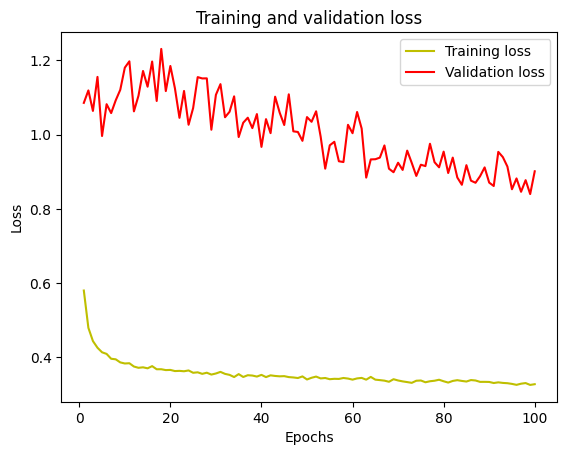

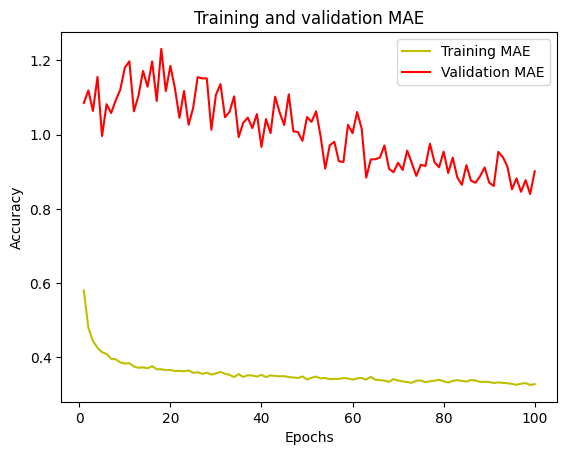

141/141 [==============================] - 0s 991us/step
Predicted values are:  [[21.988745  14.757017  42.94083    2.7738957 19.67154  ]
 [25.892162  17.856083  55.341656   3.6146774  7.842494 ]
 [27.289927  18.942001  59.40834    3.9261532  2.4034986]
 ...
 [29.883219  23.863914  40.425518   3.507522  59.684685 ]
 [26.179317  19.0037    33.9898     3.641261   6.02217  ]
 [29.875593  23.852655  40.385925   3.5057638 59.768604 ]]
Real values are:                             PM10  PM2.5  Biossido di Azoto  Biossido Zolfo  \
ts                                                                          
2022-03-24 04:00:00+00:00  22.0   14.0               36.0             2.0   
2022-03-24 05:00:00+00:00  21.0   13.0               40.0             2.0   
2022-03-24 06:00:00+00:00  19.0   13.0               54.0             3.0   
2022-03-24 07:00:00+00:00  21.0   13.0               69.0             4.0   
2022-03-24 08:00:00+00:00  22.0   14.0               74.0             5.0   
...      

In [53]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot the training and validation accuracy and loss at each epoch
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

############################################
#Predict on test data
predictions = model.predict(X_test_scaled)

predictions = scaler.inverse_transform(predictions)

y_test_ssaved = y_test_s
y_test_s = y_test
print("Predicted values are: ", predictions)
print("Real values are: ", y_test_s)


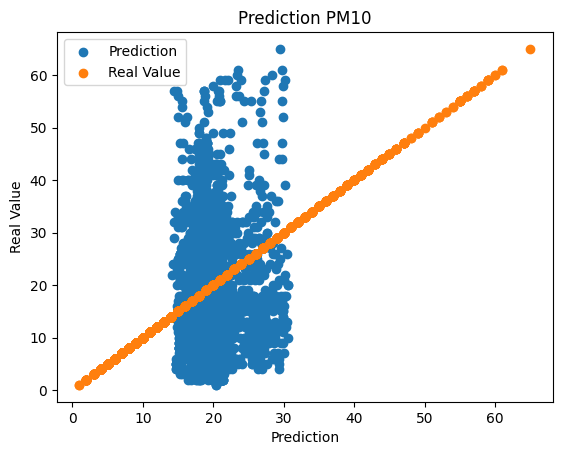

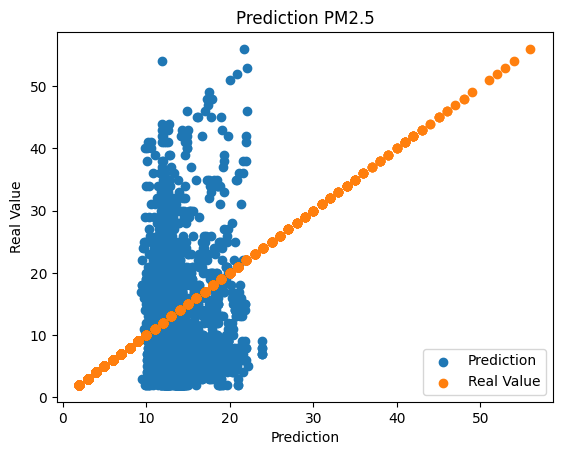

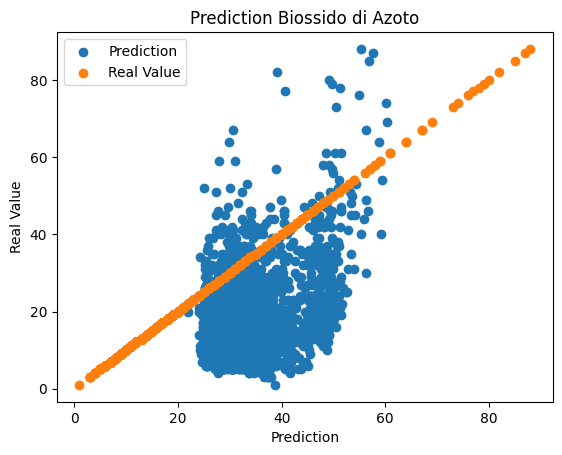

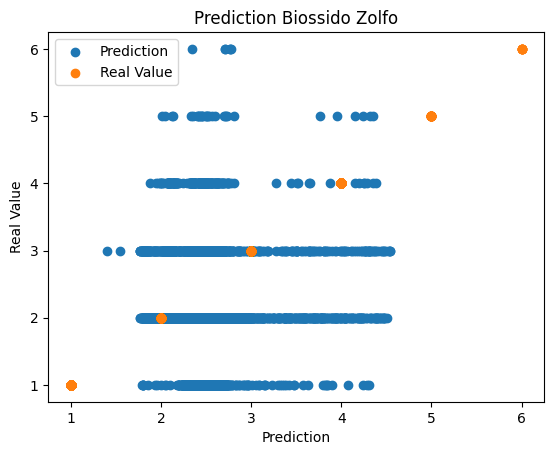

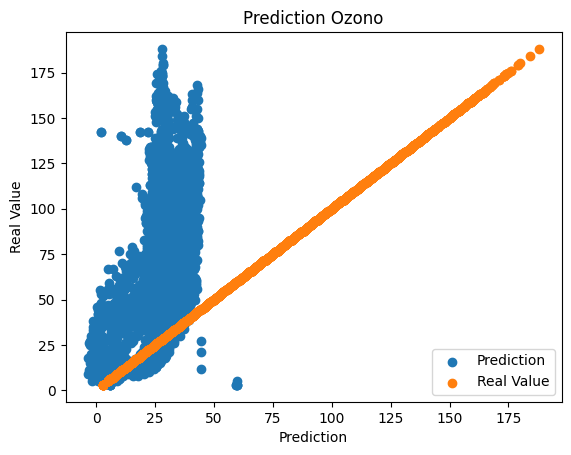

In [49]:
#Plot and compare prediction and real value
t = np.arange(0, predictions.size, 1)

for n,sens in enumerate(y_test.columns):
    plt.scatter(predictions[:,n], y_test_s[sens], label='Prediction')
    plt.scatter(y_test_s[sens], y_test_s[sens], label='Real Value')
    plt.title('Prediction '+ sens) 
    plt.xlabel('Prediction')
    plt.ylabel('Real Value')
    plt.legend()
    plt.show()

In [27]:
##Example of RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.metrics import r2_score


In [30]:
y

,PM10,PM2.5,Biossido di Azoto,Biossido Zolfo,Ozono
ts,,,,,
2021-01-13 10:00:00+00:00,34.0,25.0,81.0,7.0,7.0
2021-01-13 11:00:00+00:00,40.0,27.0,78.0,7.0,10.0
2021-01-13 12:00:00+00:00,38.0,26.0,64.0,5.0,17.0
2021-01-13 13:00:00+00:00,30.0,21.0,55.0,5.0,23.0
2021-01-13 14:00:00+00:00,28.0,21.0,56.0,5.0,21.0
...,...,...,...,...,...
2022-09-28 21:00:00+00:00,15.0,8.0,46.0,4.0,3.0
2022-09-28 22:00:00+00:00,16.0,9.0,43.0,3.0,3.0
2022-09-28 22:00:00+00:00,16.0,9.0,43.0,3.0,3.0


In [44]:
Y = y.PM10
Y
Y.values.reshape(-1, 1).shape

(15039, 1)

In [68]:
##Same thing you have done before, define an X and y from a dataset if you want to try.

x_train, x_test, y_train, y_test=train_test_split(X, Y, shuffle = True, test_size=0.20)
scaler=MinMaxScaler()
scaler2 = MinMaxScaler()
scaler.fit(x_train)

X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

scaler2.fit(y_train.values.reshape(-1, 1))

y_train = scaler2.transform(y_train.values.reshape(-1, 1))
y_test = scaler2.transform(y_test.values.reshape(-1, 1))

MinMaxScaler()

In [ ]:
rfr = RandomForestRegressor()

 
#Here are some hyperparameter of your regressor, it's a bit better and easier to look up at what the difference
#parameter does. All of this hyperparameter can be optimized using the validation data.
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=3, max_leaf_nodes=None,
                      max_samples=0.1, min_impurity_decrease=0.0,
                      min_samples_leaf=0.01,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

In [ ]:
#fit of the RandomForestRegressor

rfr.fit(X_train, y_train.reshape(-1, 1))
#evaluation of its performance by the R-squared

score = rfr.score(X_train, y_train.reshape(-1, 1))
print("R-squared:", score) 

ypred = rfr.predict(X_test)
#evaluation of its performance by the mean_squared_error

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 